# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   



In [1]:
!pip install torchsummary

In [2]:
import warnings
import os
from shutil import copyfile

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, datasets

from torchsummary import summary

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd

# Data downloading

In [3]:
from tiny_img import download_tinyImg200

# DL data, if necessary
if False==True:
    data_path = '.'
    download_tinyImg200(data_path)

In [4]:
# Create Test directory, mimicking the ImageFolder structure of train
VAL_DIR = 'tiny-imagenet-200/val'
TEST_DIR = 'tiny-imagenet-200/Test'

val_list = pd.read_csv(VAL_DIR + '/val_annotations.txt', sep='\t', header=None)

if not os.path.isdir(TEST_DIR):
    os.mkdir(TEST_DIR)

for x in val_list.iterrows():
    img = x[1][0]
    folder = TEST_DIR + '/' + x[1][1]
    
    if not os.path.isdir(folder):
        os.mkdir(folder)
        
    copyfile(VAL_DIR + '/images' + '/' + img, folder + '/' + img)

In [5]:
class MapDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        return self.map(self.dataset[index][0]), self.dataset[index][1]

    def __len__(self):
        return len(self.dataset)

## 2. Model definition and... everything else pretty much

In [6]:
class BasicModule(nn.Module):
    """Basic 2 layer 3x3 convnet block
    
    Contains 2 3*3 convolution layers. If downsampling, the first convolution layer has a stride of 2,
    and the input is passed through a 1*1 convolution layer with stride 2 before adding at the end.
    """
    
    def __init__(self, in_ch, out_ch, downsample=False):
        super(BasicModule, self).__init__()

        if downsample:
            stride = 2
            self.downsample = nn.Conv2d(in_ch, out_ch, 1, stride=2)
        elif in_ch != out_ch:
            stride = 1
            self.downsample = nn.Conv2d(in_ch, out_ch, 1, stride=1)
        else:
            stride = 1
            self.downsample = nn.Identity()
            
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
        self.relu = nn.ReLU(inplace=True)       
        
    def forward(self, input):
        
        out = self.conv1(input)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + self.downsample(input)
        out = self.relu(out)
        
        return out
    
class MyNet(pl.LightningModule):
    """Baby ResNet model
    
    This version includes 4 residual layers and 2 fully connected layers.
    
    Input: 3*64*64 image
    Layer 0: 5*5 convolution with 16 channels and stride 2
    Layer 1: 4 residual blocks of 2 3*3 convolutions with 32 channels
    Layer 2: 4 residual blocks of 2 3*3 convolutions with 64 channels
    Layer 3: 4 residual blocks of 2 3*3 convolutions with 128 channels
    
    FC1: Layer with 500 neurons (and ReLU activation)
    FC2: Layer with 200 neurons
    """
    
    def __init__(self):
        super(MyNet, self).__init__()

        # Some important variables
        self.WARMUP_EPOCHS = 10
        self.DECAY_EPOCHS = 60
        self.BATCH_SIZE = 512
        self.GAMMA = 5
        self.VAL_SIZE = int(1e4)
        
        initial_channel = 32
        
        self.layer_0 = nn.Conv2d(3, initial_channel, 5, padding=2, stride=1)
        self.layer_1 = self._make_layer(3, initial_channel, initial_channel*2) # Returns 32 * 32
        self.layer_2 = self._make_layer(6, initial_channel*2, initial_channel*4) # Returns 16 * 16
        self.layer_3 = self._make_layer(6, initial_channel*4, initial_channel*8) # Returns 8 * 8
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc1 = nn.Linear(initial_channel * 8, 200)       

    def _make_layer(self, n_blocks, in_ch, out_ch, downsample=True):
        
        blocks = [BasicModule(in_ch, out_ch, downsample=downsample)]        
        for i in range(n_blocks - 1):
            blocks.append(BasicModule(out_ch, out_ch))
            
        return nn.Sequential(*blocks)
        
    def forward(self, input):
        
        out = self.layer_0(input)
        out = self.layer_1(out)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.avg_pool(out)

        out = torch.flatten(out, start_dim=1)
        out = self.fc1(out)
                
        return out

    def prepare_data(self):
        transforms_train = transforms.Compose([
           transforms.ColorJitter(hue=.05, saturation=.05),
           transforms.RandomHorizontalFlip(),
           transforms.RandomRotation(20, expand=True),
           transforms.RandomResizedCrop(64, scale=(0.6, 1.0)),
           transforms.ToTensor(),
           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        transforms_val = transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])   
        
        # Load and split data
        full_set = datasets.ImageFolder(root='tiny-imagenet-200/train')
        test_set = datasets.ImageFolder(root='tiny-imagenet-200/Test')        
        
        train_size, val_size = len(full_set)-self.VAL_SIZE, self.VAL_SIZE
        train_set, val_set = torch.utils.data.random_split(full_set, (train_size, val_size))
    
        # The class labels better be the same - else we have a problem
        assert test_set.class_to_idx == full_set.class_to_idx, "Test and train labels don't match"

        self.train_set = MapDataset(train_set, transforms_train)
        self.val_set = MapDataset(val_set, transforms_val)
        self.test_set = MapDataset(test_set, transforms_val)
        
    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.BATCH_SIZE, num_workers=8, pin_memory=True)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_set, batch_size=self.BATCH_SIZE, num_workers=8, pin_memory=True)
    
    def configure_optimizers(self):
        steps_per_epoch = len(self.train_dataloader())
        total_epochs = self.WARMUP_EPOCHS + self.DECAY_EPOCHS
        
        optimizers = [optim.Adam(self.parameters(), weight_decay=1e-4)]
        schedulers = [
            {
                'scheduler': OneCycleLR(optimizers[0], 0.01, epochs=total_epochs, steps_per_epoch=steps_per_epoch,
                                        pct_start=self.WARMUP_EPOCHS/total_epochs),
                'interval': 'step'
            }
        ]
            
        return optimizers, schedulers
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # add logging
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        labels_hat = torch.argmax(logits, dim=1)
        n_correct_pred = torch.sum(y == labels_hat).item()
        return {'val_loss': loss, "n_correct_pred": n_correct_pred, "n_pred": len(x)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_acc = sum([x['n_correct_pred'] for x in outputs]) / sum(x['n_pred'] for x in outputs)
        
        tensorboard_logs = {'val_loss': avg_loss, 'val_acc': val_acc}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        labels_hat = torch.argmax(logits, dim=1)
        n_correct_pred = torch.sum(y == labels_hat).item()
        
        return {'test_loss': loss, "n_correct_pred": n_correct_pred, "n_pred": len(x)}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        test_acc = sum([x['n_correct_pred'] for x in outputs]) / sum(x['n_pred'] for x in outputs)
        
        tensorboard_logs = {'test_loss': avg_loss, 'test_acc': test_acc}
        return {'test_acc': test_acc, 'log': tensorboard_logs}

## Initialization

In [7]:
# Create the net
net1 = MyNet()

In [8]:
# Alternatively, load it from device!
# net1 = MyNet.load_from_checkpoint(checkpoint_path="winrar.ckpt")

In [9]:
# Initialize all weights (He initialization)
def init_fn(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    
net1 = net1.apply(init_fn)

## See summary of the model

In [10]:
#summary(net1, (3, 64, 64), device='cpu')

## Learning rate scheduler

/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:1205: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


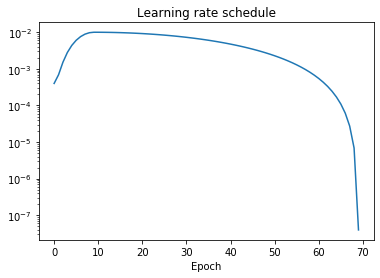

In [11]:
# Plot LR scheduler
lr_graph = []
dummy_module = nn.Sequential(nn.Linear(1, 1))
dummy_opt = optim.SGD(dummy_module.parameters(), lr=0.1)
total_epochs = net1.WARMUP_EPOCHS + net1.DECAY_EPOCHS
        
sch = OneCycleLR(dummy_opt, 0.01, epochs=total_epochs, steps_per_epoch=1,
                  pct_start=net1.WARMUP_EPOCHS/total_epochs)

for i in range(total_epochs):
    lr_graph.append(sch.get_lr()[0])
    sch.last_epoch += 1

plt.plot(lr_graph)
plt.yscale('log')
plt.title('Learning rate schedule')
_ = plt.xlabel('Epoch')

# RUUUUUUUUUUUUUUUUUUUUUUUUUUUUNNNN!

In [ ]:
logger = pl.loggers.TensorBoardLogger("tb_logs", name="my_model")
save_path = os.path.join(os.getcwd(), 'model_checkpoints')
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, mode='min')
checkpoint_callback = ModelCheckpoint(filepath=save_path, monitor='val_loss', mode='min')

trainer = pl.Trainer(gpus=1, precision=16, amp_level='O2',
                    logger=logger, 
                    early_stop_callback=early_stop_callback,
                    checkpoint_callback=checkpoint_callback,
                    max_epochs=net1.WARMUP_EPOCHS+net1.DECAY_EPOCHS,
                    weights_summary=None)
trainer.fit(net1)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory /root/project/model_checkpoints exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
Using 16bit precision.
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: you called `module.module_arguments` without calling self.auto_collect_arguments()
  warnings.warn(*args, **kwargs)


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: you called `module.module_arguments` without calling self.auto_collect_arguments()
  warnings.warn(*args, **kwargs)


In [ ]:
trainer.test(net1)

When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

In [ ]:
test_accuracy = 0.5486805277888844

In [ ]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `Slim Shady`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

#### I gonna build a neural network, that

Was basically a simpler version of the classic [ResNet](https://arxiv.org/abs/1512.03385) network. I could go into details why, but that would just be copying the paper... There wasn't really that much iterating on the architecture part, since I was set on doing a resnet form the beginning. I did mess around with the number/depth of blocks, but this only seemed to impact the speed of training and not the accuracy.

Since this is the kind of network when training on GPU really makes a difference, I spent some time learning how to properly do that. After some initial attempts, I realized that training a model with pure pytorch is really messy, especially if you want to do some "fancy" stuff like logging, checkpoints, etc. So I started exploring frameworks: I started with `ignite` and moved to `Pytorch Lightning`, which is supposed to be state of the art. Tbh, it's still light years behind keras, but it's getting there.

If I move on to non-technical stuff, what really propelled my model into space (15% over full points benchmark, take that) was the use of a warmup LR scheduler. I could write some smart paragraphs on why this is good, but honestly, I like it bc it simply works. The model actually overfits a lot (loss ~1 on train and ~1.9 on val), so there's still lots of room for improvement.

#### One day, with no signs of warning,
This thing has finally converged and I was shocked at the result! I was most happy about how GPU really sped things up (I am using RTX 2070 Super), and that warmup helped. Just based on my observation I think  it would be good to experiement with warmup a bit more -- the decline would need to be log linear -- and not linear as it is now. I did try to implement this, but beside from faster initial (but not final) convergence, it did not seem to yield any improvement. Also, Pytorch LR schedulers could be improved.

I'll be paying a lot more attention to useful LR schedulers moving forward. Perhaps I should also experiement with optimizers a bit, but I've already spent a ton of time here, so I think it's time to move on.

#### Finally, after $\infty$  iterations, 0 mugs of [tea/coffee] (don't really drink either)

* accuracy on training: Waiting for Pytorch Lightning to implement this 😠
* accuracy on validation: 55%
* accuracy on test: 55%